Assignment 3: 

Name: Shubham Ramraja Takbhate

UID:118359502

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Shubham

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow
%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [2]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 92.7MB/s]
Archive:  /content/Part1_data.zip
replace /content/Part1_data/chapel00.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [3]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

x11=np.array(x1)
y11=np.array(y1)
x22=np.array(x2)
y22=np.array(y2)
feature1=np.hstack((x11,y11))
feature2=np.hstack((x22,y22))

## Helper Functions

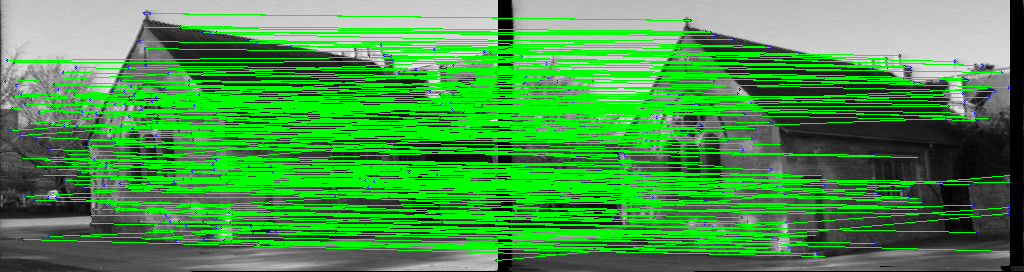

In [4]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()
def drawMatches(img1, x_1,y_1, img2, x_2,y_2):
    #This function displays the key points using eqaution of lines
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

   
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

   
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])
    for i in range (len(x_1)):
        (x1,y1) =x_1[i],y_1[i]
        (x2,y2) = x_2[i],y_2[i]

  
        cv2.circle(out, (int(x1),int(y1)), 1, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 1, (255, 0, 0), 1)

       
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 1)

   
    return out

img1 = cv2.imread('/content/Part1_data/chapel00.png',0)  #queryimage # left image
img2 = cv2.imread('/content/Part1_data/chapel01.png',0) 
keyptsimg=drawMatches(img1.copy(), x1,y1, img2.copy(), x2,y2)    
cv2_imshow(keyptsimg)

### Code (15 pt)

Best Fundamental matrix after Normalising to unit vector [[ 5.88235828e-07 -1.01209368e-04  1.77463061e-02]
 [ 1.49608210e-04  1.39259782e-05  2.86225355e-01]
 [-2.62104073e-02 -3.02415038e-01 -9.08635373e-01]]


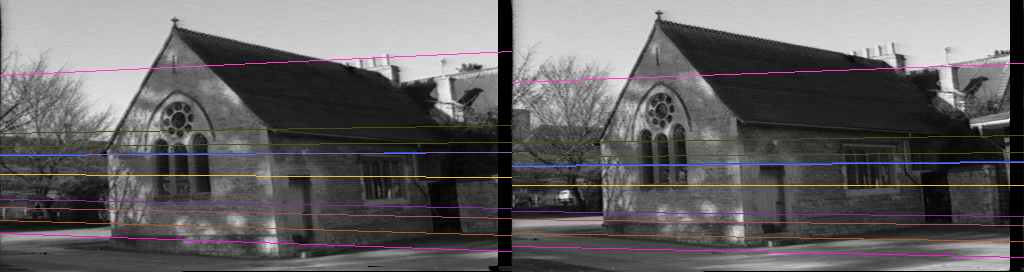

In [5]:
def NormalizePoints(pts):
  #Function to normalize the points
  
  #Mean of the points
  mu1= np.mean(pts, axis = 0)

  #Mean normalize the points
  pts1c = pts - mu1
  #Find the standard deviation of the data
  std1 = np.sqrt(2) / np.mean(np.sqrt(np.sum(pts1c**2, axis=1)))
  #Find the transformation matrix
  T = np.array([[std1, 0, -std1 *mu1[0]], [0, std1, -std1 * mu1[1]],[0, 0, 1]])
  #Convert to homogeneous coordinates
  pts_h = np.column_stack((pts, np.ones(len(pts))))
  pts_h_T = pts_h.T
  pts_norm = (np.dot(T, pts_h_T)).T
  pts_norm=np.delete(pts_norm,2,1)
  #Return the points
  return pts_norm, T

def fundamental_matrix(pf1,pf2):
    #Function to find fundamental matrix using Ransac
    total_points = pf2.shape[0]
    points1,T1m= NormalizePoints(pf1)
    points2,T2m= NormalizePoints(pf2)
    A = np.zeros((total_points, 9))
    for i in range(total_points):
        u1 = points1[i][0]
        v1 = points1[i][1]
        u2 = points2[i][0]
        v2 = points2[i][1]
        A[i] = np.array([u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1])
      

    # compute F
    U, s, VT = np.linalg.svd(A)
    f = VT[-1, :]
    F_hat = np.reshape(f, (3, 3))
    F_hat=F_hat

    # Apply rank 2
    U1, s_hat, VT2 = np.linalg.svd(F_hat)
    s_hat[2]=0
    F= np.dot(U1, np.dot(np.diag(s_hat), VT2)) 
    #Denormalize the fundamental Matrix
    F = np.dot(T2m.T,np.dot(F,T1m))

    return F

def ransac_fundamental_matrix(matches_a, matches_b):

    #Ransac function for fundamental matrix
    num_iterator = 10000
    # num_iterator = 10000
    threshold = 0.005
  
    Best_F = np.zeros((3, 3))
    max_inliers = 0
    num_sample_rand = 8
    num_points=matches_a.shape[0]
    for i in range(num_iterator):
        index_rand = np.random.randint(matches_a.shape[0], size=num_sample_rand)
        F = fundamental_matrix(matches_a[index_rand, :], matches_b[index_rand, :])
        tmp_inliers_img1 = []
        tmp_inliers_img2 = []

        for i in range(num_points):
            img1_x = np.array([matches_a[i][0], matches_a[i][1], 1])
            img2_x = np.array([matches_b[i][0], matches_b[i][1], 1])
            distance = abs(np.dot(img2_x.T, np.dot(F,img1_x)))
            if distance < threshold:
                tmp_inliers_img1.append(matches_a[i])
                tmp_inliers_img2.append(matches_b[i])

        num_of_inliers = len(tmp_inliers_img1)
        if num_of_inliers > max_inliers:
            max_inliers = num_of_inliers
            Best_F = F
            inliers_img1 = tmp_inliers_img1
            inliers_img2 = tmp_inliers_img2
            

    return Best_F,np.array(inliers_img1),np.array(inliers_img2)


Best_F,Pi1,Pi2=ransac_fundamental_matrix(feature1,feature2)
Pi1=Pi1[0:10,0:10]
Pi2=Pi2[0:10,0:10]
print("Best Fundamental matrix after Normalising to unit vector",Best_F/np.linalg.norm(Best_F))

def drawlines(img1src, img2src, lines, pts1src, pts2src):
    
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        
    return img1color, img2color
point1=np.int64(Pi1)
point2=np.int64(Pi2)

ones_col = np.ones((point1.shape[0],1))
pts2new = np.hstack((point1,ones_col))
p2=np.dot(Best_F,pts2new.T)
ones_col = np.ones((point1.shape[0],1))
pts2new = np.hstack((point1,ones_col))
p2=np.dot(Best_F,pts2new.T)
p2=p2.T
lines1=p2.reshape((p2.shape[0],1, p2.shape[1]))
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, point1 , point2)  
ones_col = np.ones((point2.shape[0],1))
pts2new = np.hstack((point2,ones_col))

p2=np.dot(Best_F.T,pts2new.T)
p2=p2.T
lines2=p2.reshape((p2.shape[0],1, p2.shape[1]))
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, point2, point1)
im_h = cv2.hconcat([img3, img5])
cv2_imshow(im_h)


### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.
*   Display the estimated fundamental matrix F after normalizing to unit length
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



1. Inlier vs outlier \
Here we have to define an error function. We know that $x'^T$$F$$x$ =0. Hence we can use this information for defining the error function. We can iteratively find the Fundamental matrix and use the above mentioned equation and get the error. According to mathematical derivation the error should 0. But that is not the case. Hence we set a threshold of error. If the error is less than the threshold for a feature point then we can select it as an inlier. \
We had total of 251 feature points with us. But after Ransac only 113-115 will be the inliers.

### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


How to decide in

# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [6]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 71.7MB/s]
Archive:  /content/hill.zip
replace /content/hill/1.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 87.4MB/s]
Archive:  /content/tv.zip
replace /content/tv/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [7]:
import cv2

def NormalizePoints(pts):
  #Same function used above in the part 1
  mu1= np.mean(pts, axis = 0)
  pts1c = pts - mu1
  std1 = np.sqrt(2) / np.mean(np.sqrt(np.sum(pts1c**2, axis=1)))
  T = np.array([[std1, 0, -std1 *mu1[0]], [0, std1, -std1 * mu1[1]],[0, 0, 1]])
  pts_h = np.column_stack((pts, np.ones(len(pts))))
  pts_h_T = pts_h.T
  pts_norm = (np.dot(T, pts_h_T)).T
  pts_norm=np.delete(pts_norm,2,1)

  return pts_norm, T 
def est_homography(src, dest):
    #Function for finding the Homography 
    #Using eight point algorithm
    srcn,T1=NormalizePoints(src)
    destn,T2=NormalizePoints(dest)
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((srcn, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -destn[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -destn[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    H =V.T[:, 8].reshape(3, 3)
    Hdnorm=np.linalg.inv(T2) @ H @ T1
    return Hdnorm

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
  
    return (dest / dest[:,[2]])[:,0:2]


def FindHomographyRansac(matches_a,matches_b,threshold):
    #Function for finding the Homography matrix using RANSAC
    num_iterator = 10000
   
    Best_H = np.zeros((3, 3))
    max_inliers = 0
    num_sample_rand = 8
    num_points=matches_a.shape[0]


 
    for i in range(num_iterator):
     
        index_rand = np.random.randint(matches_a.shape[0], size=num_sample_rand)
        Hnorm = est_homography(matches_a[index_rand, :], matches_b[index_rand, :])
        tmp_inliers_img1 = []
        tmp_inliers_img2 = []
        dest2=apply_homography(Hnorm,matches_a)
        for i in range(num_points):
            #Distance
            distance=np.sqrt((dest2[i][0]-matches_b[i][0])**2+(dest2[i][1]-matches_b[i][1])**2)
          
            if distance < threshold:
                tmp_inliers_img1.append(matches_a[i])
                tmp_inliers_img2.append(matches_b[i])
                

        num_of_inliers = len(tmp_inliers_img1)
        if num_of_inliers > max_inliers:
           
            max_inliers = num_of_inliers
            Best_H = Hnorm

            inliers_img1 = tmp_inliers_img1
            inliers_img2 = tmp_inliers_img2
    
    return Best_H,np.array(inliers_img1),np.array(inliers_img2)


### Code (15 pt)

Homography for image1to2 [[ 5.34137740e-01  2.85391923e-02  8.65919840e+01]
 [-5.09794245e-02  5.78998976e-01 -6.93682472e+00]
 [-1.61456992e-04  7.57053011e-06  5.97068867e-01]]
Homography for image2to3 [[-4.64284398e-01 -2.50682400e-02 -3.19402416e+02]
 [ 2.87697683e-02 -5.84905778e-01  9.75563366e+00]
 [ 1.73055256e-04 -3.16840972e-05 -5.96385833e-01]]


<Figure size 432x288 with 0 Axes>

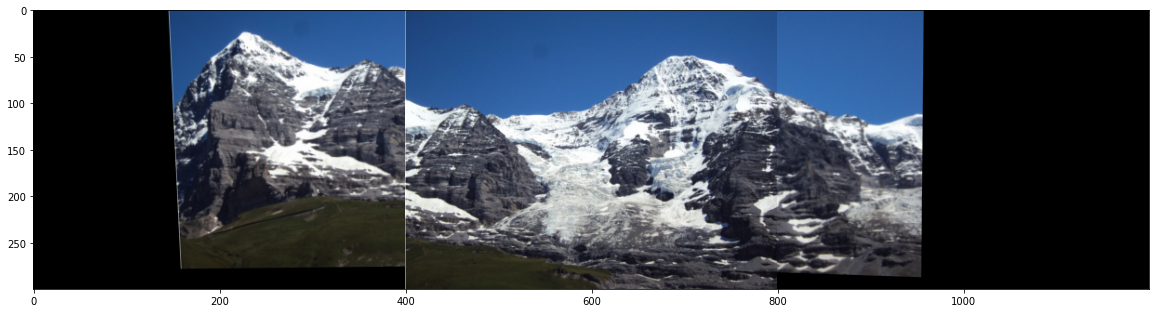

In [8]:
from operator import inv
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

def get_key_points(img1g,img2g):
  #Use sift descriptor for finding the keypoints
  sift = cv2.xfeatures2d.SIFT_create()
  # find key points
  kp1, des1 = sift.detectAndCompute(img1g,None)
  kp2, des2 = sift.detectAndCompute(img2g,None)
  # find similar points and match them with two given images
  match = cv2.BFMatcher()
  matches = match.knnMatch(des1,des2,k=2)

  good = []
  for m,n in matches:
      if m.distance < 0.4*n.distance:#define a threshhold
          good.append(m)

  draw_params = dict(matchColor=(0,255,0),
                        singlePointColor=None,
                        flags=2)


  MIN_MATCH_COUNT = 15
  if len(good) > MIN_MATCH_COUNT:
      pts1 = [list(kp1[m.queryIdx].pt) for m in good] 
      pts2 = [list(kp2[m.trainIdx].pt) for m in good]
      pts1 = np.int32(pts1)
      pts2 = np.int32(pts2) 
  return pts1,pts2    

def stich_img(img_,img,img3):

  gray1= cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
  RGB1=cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
  gray2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  RGB2=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
  RGB_img3=cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)


  pts1,pts2=get_key_points(gray1,gray2)
  M,p1,p2=FindHomographyRansac(pts2,pts1,2)
  print("Homography for image1to2",M)
  img1to2 = np.zeros((gray1.shape[0] , gray1.shape[1]+gray2.shape[1]) , dtype = np.uint8)
  img1to2[: , gray1.shape[1]:] = gray2


  dst = cv2.warpPerspective(RGB1 ,M,(img1.shape[1] + img2.shape[1], img2.shape[0]))
  dst[:, img2.shape[1]:] = RGB2
  pts22,pts23=get_key_points(dst, gray3)
  M,p1,p2=FindHomographyRansac(pts23,pts22,2)
  print("Homography for image2to3",M)
  stiched_img = cv2.warpPerspective(RGB_img3 ,(M),(dst.shape[1] + gray3.shape[1], gray3.shape[0]))
  stiched_img[:, :dst.shape[1]] = dst
  plt.figure()
  plt.figure(figsize = (20, 20))
  plt.imshow(stiched_img,cmap = 'gray')

  return stiched_img

img1 = cv2.imread('/content/hill/1.JPG')  
img2 = cv2.imread('/content/hill/2.JPG')
img3 = cv2.imread('/content/hill/3.JPG') 

newsrc=stich_img(img1,img2,img3)



Homography for image1to2 [[ 3.98874710e-01 -6.21880018e-03  1.66266220e+02]
 [-1.43044123e-01  5.69635403e-01  1.71063002e+01]
 [-4.75433066e-04 -8.78802417e-08  6.21598981e-01]]
Homography for image2to3 [[-3.06338720e-01  2.25271620e-02 -4.28443471e+02]
 [ 9.23025087e-02 -5.59837069e-01 -1.64568342e+01]
 [ 3.21991553e-04  2.52617945e-05 -6.22349811e-01]]


<Figure size 432x288 with 0 Axes>

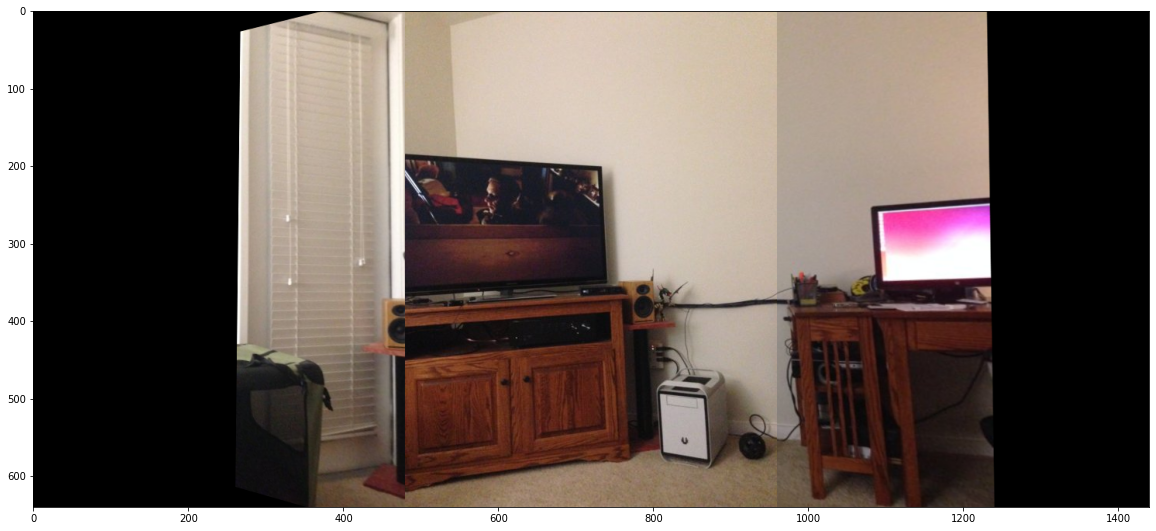

In [9]:
img1 = cv2.imread('/content/tv/1.jpg')  #queryimage # left image
img2 = cv2.imread('/content/tv/2.jpg')
img3 = cv2.imread('/content/tv/3.jpg')  #trainimage # right image

newsrc=stich_img(img1,img2,img3)

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC 
*  Display the best homography H after RANSAC 
*  Display the blended images

We find the keypoints in the source image. The source image is the image which we will warp or map on to a destination image. Hence we will find the keypoints in the destination. \
$($∥$dstPoints_{i}$−$convertPointsHomogeneous$($H⋅srcPoints_{i}$)∥)$< ($$ransacReprojThreshold$) \

Then we can define a distance function as mentioned above. The distance function is a $L_{2}$$norm$. We have intial destination points and find the destination points using homography and source points. And then compute the error between calculated destination points and original destination points. If the error is less than say 2 pixels then select the point as an inlier.

### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [10]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 140MB/s]
Archive:  /content/Part2_data.zip
replace /content/Part2_data/images/hotel.seq0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2

### Code (20 pt)

(153, 9)
(400, 3)


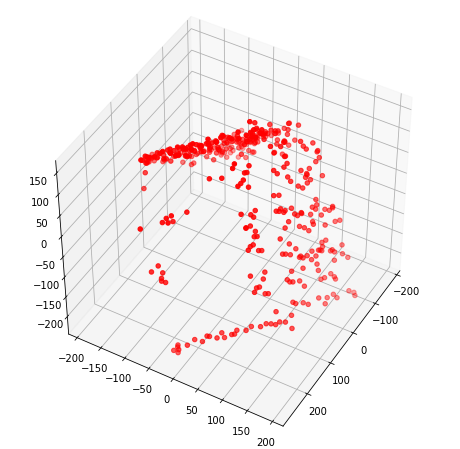

In [11]:
from scipy.linalg import svd
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

rc('animation', html='jshtml')
track_x = data['track_x']
track_y = data['track_y']
x_1=track_x[~np.isnan(track_x).any(axis=1), :]
y_1=track_y[~np.isnan(track_y).any(axis=1), :]
def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  xn=x-x.mean(axis=0,keepdims=True)
  yn=y-y.mean(axis=0,keepdims=True)
  W=np.concatenate((xn.T, yn.T), axis=0)
  O1, S, O2 = np.linalg.svd(W, full_matrices=True)

  O1_prime= O1[:, 0:3]
  S_prime= np.diag(S)[0:3,0:3]
  O2_prime= O2[0:3, :]
  R_hat=O1_prime@np.sqrt(S_prime)
  S_hat=np.sqrt(S_prime)@O2_prime
  R_hat_i = np.array(R_hat[0:51,:],dtype=np.float32)

  R_hat_j = np.array(R_hat[51:102,:],dtype=np.float32)
  L=np.zeros((1,9),dtype=np.float32)
  b=np.zeros((1,1),dtype=np.float32)

  i_nor=np.array([[0,0,0]],dtype=np.float32)
  j_nor=np.array([[0,0,0]],dtype=np.float32)
  
 
  for i in range(51):
    el1=R_hat_i[i]
    i_nor[0][0]=el1[0]
    i_nor[0][1]=el1[1]
    i_nor[0][2]=el1[2]
    i_dash=i_nor.T
    cond1=np.reshape((i_dash@i_nor),(1,9))
    el2=R_hat_j[i]
    j_nor[0][0]=el2[0]
    j_nor[0][1]=el2[1]
    j_nor[0][2]=el2[2]
    j_dash=j_nor.T
    cond2=np.reshape((j_dash@j_nor),(1,9))
    cond3=np.reshape((i_dash@j_nor),(1,9))
    L=np.vstack((L,cond1,cond2,cond3))
    b_prime=np.array([[1],[1],[0]],dtype=np.float32)
    
    b=np.vstack((b,b_prime))
  L=np.delete(L, (0), axis=0)
  b=np.delete(b, (0), axis=0)

  print(L.shape)
 

  QQt=np.matmul(np.linalg.pinv(L), b)
  QQt=np.reshape((QQt),(3,3))
  Q=np.linalg.cholesky(QQt)
  R=R_hat@Q
  S=np.linalg.inv(Q)@S_hat
  S=S.T
  print(S.shape)
  
  fig = plt.figure(figsize = (8, 8))
  ax = plt.axes(projection = '3d')
  ax.scatter3D(S[:, 0], S[:, 1], S[:, 2], c='red')
 
  elev=45
  azim=30
  ax.view_init(elev, azim)
  i_k1 = np.array(R[0:51,:],dtype=np.float32)

  j_k1 = np.array(R[51:102,:],dtype=np.float32)

  i_k=np.array([[0,0,0]],dtype=np.float32)
  j_k=np.array([[0,0,0]],dtype=np.float32)
  k=np.ones((1,3),dtype=np.float32)

  for i in range(51):
    el1=i_k1[i]
    i_k[0][0]=el1[0]
    i_k[0][1]=el1[1]
    i_k[0][2]=el1[2]
    el2=j_k1[i]
    j_k[0][0]=el2[0]
    j_k[0][1]=el2[1]
    j_k[0][2]=el2[2]
    crossp=(np.cross(i_k,j_k))
    vectormorm=crossp/np.linalg.norm(crossp)
    k=np.vstack((k,vectormorm))
  k=np.delete(k, (0), axis=0)  
 
  return W,k,S

W,k,S=affineSFM(x_1,y_1) 



In [12]:
from plotly.offline import iplot
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.

# Configure the trace.
trace = go.Scatter3d(
    x=S[:,0],  # <-- Put your data instead
    y=S[:,1],  # <-- Put your data instead
    z=S[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 2,
        'opacity': 0.9,'color':'red'
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
# Render the plot.

iplot(plot_figure)

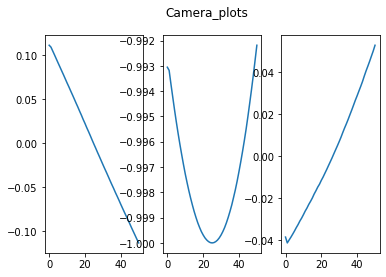

In [13]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.suptitle('Camera_plots')
ax1.plot(k[:,1])
ax2.plot(k[:,2])
ax3.plot(k[:,0])

### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992